# Social Engineering Scam Detection with LLMs

In [1]:
import os

### Imports

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import torch, re
import random
import json
import ollama


from nltk.corpus import stopwords
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from tqdm import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/VyasSrinivasan/opt/anaconda3/envs/llm/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/VyasSrinivasan/opt/anaconda3/envs/llm/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/VyasSrinivasan/opt/anaconda3/envs/llm/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/VyasSrinivasan/opt/anaconda3/envs/llm/lib/python3.10/site-packages/t

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/VyasSrinivasan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Datasets

In [4]:
#Email
df_email = pd.read_csv("./data/email.csv")
df_email.columns = ["Category", "Message"]

df_email.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#SMS
df_smsText = pd.read_csv("./data/Spam_SMS.csv")
df_smsText.columns = ["Category", "Message"]

df_smsText.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#UCI SMS
df_uciSmsText = pd.read_csv("./data/SMSSpamCollection", sep="\t", header=None, names=["Category", "Message"])
df_uciSmsText.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
phishingFiles = ["CEAS_08", "Enron", "Ling", "Nazario", "Nigerian_Fraud", "phishing_email", "SpamAssasin"]

In [8]:
phishDF = []
for phishFile in phishingFiles:
    try:
        df_temp = pd.read_csv("./data/Phishing/" + phishFile + ".csv")
        df_temp = df_temp.iloc[:, :2]
        df_temp.columns = ["Category", "Message"]
        phishDF.append(df_temp)
        
    except Exception as e:
        print("Error loading ./data/Phishing/"+phishFile+ ".csv : " + e)
        

### Combine Datasets

In [9]:
df = pd.concat([df_smsText, df_email, df_uciSmsText] + phishDF, ignore_index=True)
df.dropna(subset=["Category", "Message"], inplace=True)

### Data Cleaning

In [10]:
df["Category"] = df["Category"].astype(str).str.lower().str.strip()
df = df[df["Category"].isin(["spam", "ham"])]
df["Category"] = df["Category"].map({"spam": 0, "ham": 1})
df.dropna(inplace=True)

print(f"Total Samples Before Balancing: {df.shape[0]}")

Total Samples Before Balancing: 16718


### Original distribution

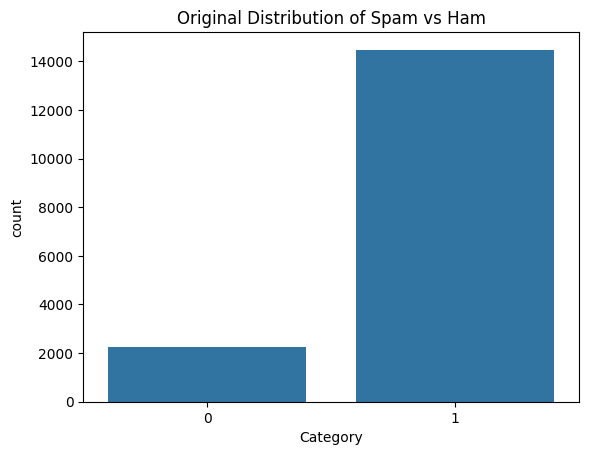

In [11]:
sns.countplot(data=df, x="Category")
plt.title("Original Distribution of Spam vs Ham")
plt.show()

### Balanced Distribution

In [12]:
spam_df = df[df["Category"] == 0]
ham_df = df[df["Category"] == 1].sample(len(spam_df), random_state=42)
df_balanced = pd.concat([spam_df, ham_df]).sample(frac=1, random_state=42)

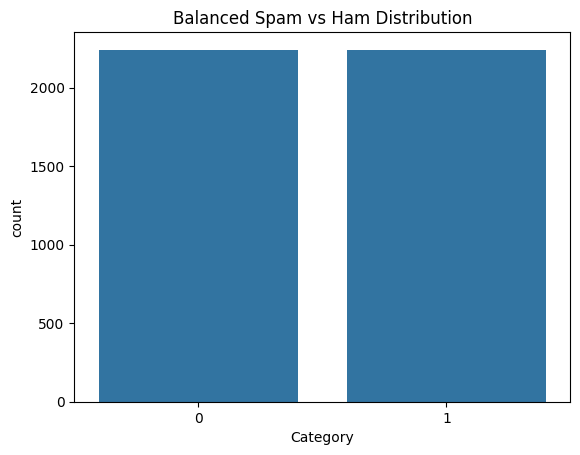

In [13]:
sns.countplot(data=df_balanced, x="Category")
plt.title("Balanced Spam vs Ham Distribution")
plt.show()

### Train/test split

In [14]:
X = df_balanced["Message"]
Y = df_balanced["Category"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

###  Feature Extraction

In [15]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [16]:
# Train model

model = LogisticRegression()
model.fit(X_train_features, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [17]:
# Evaluate model
train_pred = model.predict(X_train_features)
test_pred = model.predict(X_test_features)

In [18]:
print("Accuracy (Training):", accuracy_score(Y_train, train_pred))
print("Accuracy (Testing):", accuracy_score(Y_test, test_pred))

Accuracy (Training): 0.9896792189679219
Accuracy (Testing): 0.9743589743589743


###  Confusion Matrix

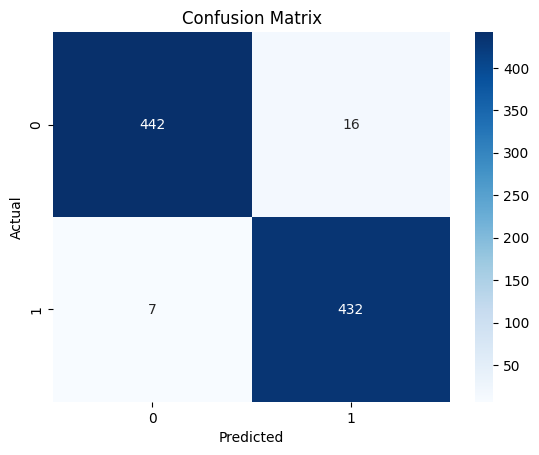

In [19]:
cm = confusion_matrix(Y_test, test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
prompt = "Classify the message as exactly one word: \"Spam\" or \"Ham\". Reply with only that word, no punctuation. If unsure, pick the most likely label."

In [21]:
def ollamaClassifier(text, prompt, modelName="mistral"):
    resp = ollama.chat(
        model=modelName,                  
        messages=[{"role": "user", "content": f"Message:\'\n{text}\'\n\n" + prompt}],
        options={"temperature": 0.0, "num_predict": 10} 
    )
    #print(resp)
    raw = resp['message']['content'].strip()
    #print(raw)
    
    if re.search(r"\bspam\b", raw.lower()):
        return "Spam", raw
    elif re.search(r"\bham\b", raw.lower()):
        return "Ham", raw
    else:
        return "Unknown", raw

In [22]:
# Test the  model
new_messages = ["Congratulations! You have won a free ticket to Bahamas! Click here.",
                "Hey are we still on for lunch today?"]
new_features = vectorizer.transform(new_messages)
predictions = model.predict(new_features)


for msg, pred in zip(new_messages, predictions):
    label = "Ham" if pred == 1 else "Spam"
    labelLLM, rawLLM = ollamaClassifier(msg, prompt)
    print(f"Message: {msg}\nPrediction LR: {label}\nLLM Prediction: {labelLLM}\nRaw: {rawLLM}\n")


Message: Congratulations! You have won a free ticket to Bahamas! Click here.
Prediction LR: Spam
LLM Prediction: Spam
Raw: Spam

Message: Hey are we still on for lunch today?
Prediction LR: Ham
LLM Prediction: Ham
Raw: Ham



In [23]:
import time

def predict_message_with_llm(msg,prompt):
    features = vectorizer.transform([msg])
    
    start_time = time.time()  # Start timer
    result = model.predict(features)[0]
    end_time = time.time()    # End timer
    
    label = "Ham" if result == 1 else "Spam"
    duration = (end_time - start_time) * 1000  # in milliseconds
    labelLLM, rawLLM = ollamaClassifier(msg,prompt)
    print(f"Message: {msg}")
    print(f"Prediction LR: {label}")
    print(f"Prediction LLM: {labelLLM}")
    print(f"Prediction Time: {duration:.4f} ms")

In [24]:
user_msg = input("Enter a message to check: ")
predict_message_with_llm(user_msg, prompt)

Enter a message to check: Amazon: Congratulations Aashish, you came in 1st in this week's Amazon Earpods raffle! Click the link to arrange shipment: u5fxc.info/ ZEJTTZmY3Z
Message: Amazon: Congratulations Aashish, you came in 1st in this week's Amazon Earpods raffle! Click the link to arrange shipment: u5fxc.info/ ZEJTTZmY3Z
Prediction LR: Spam
Prediction LLM: Spam
Prediction Time: 1.2662 ms


In [25]:
print ("Logistic Regression: ")
print(classification_report(Y_test, test_pred, target_names=["Spam", "Ham"]))

Logistic Regression: 
              precision    recall  f1-score   support

        Spam       0.98      0.97      0.97       458
         Ham       0.96      0.98      0.97       439

    accuracy                           0.97       897
   macro avg       0.97      0.97      0.97       897
weighted avg       0.97      0.97      0.97       897



In [26]:
X_sub = X_test #.sample(200, random_state=42)
y_true = Y_test.loc[X_sub.index]

y_pred_llm = []

for msg in tqdm(X_sub):
    label, raw = ollamaClassifier(msg, prompt)
    if label == "Spam":
        y_pred_llm.append(0)
    elif label == "Ham":
        y_pred_llm.append(1)
    else:
        y_pred_llm.append(-1)
        
y_pred_llm = np.array(y_pred_llm)

100%|███████████████████████████████████████████████████████████████████████████████████████| 897/897 [07:38<00:00,  1.96it/s]


In [27]:
print ("LLMs: ")
print(classification_report(y_true, y_pred_llm, target_names=["Spam", "Ham"]))

LLMs: 
              precision    recall  f1-score   support

        Spam       0.90      0.95      0.93       458
         Ham       0.95      0.89      0.92       439

    accuracy                           0.92       897
   macro avg       0.93      0.92      0.92       897
weighted avg       0.93      0.92      0.92       897



In [28]:
def pasteEmail():
    import time
    # Ask user to paste their email
    print("Paste the full email content below (e.g., subject + body):\n")
    email_text = input("Email: ")
    
    # Transform with vectorizer
    features = vectorizer.transform([email_text])

    # Predict
    start_time = time.time()
    result = model.predict(features)[0]
    end_time = time.time()
    
    labelLLM, rawLLM = ollamaClassifier(msg, prompt)
    
    # Result
    label = "Ham (Safe Message)" if result == 1 else "Spam/Phishing"
    labelLLMres = "Ham (Safe Message)" if labelLLM == "Ham" else "Spam/Phishing"
    print("\nEmail Content Preview:")
    print("-" * 60)
    print(email_text[:300] + ("..." if len(email_text) > 300 else ""))
    print("-" * 60)
    print(f"Prediction LR: {label}")
    print(f"Prediction LLM: {labelLLMres}")
    print(f"Prediction Time: {(end_time - start_time)*1000:.2f} ms")

In [29]:
pasteEmail()

Paste the full email content below (e.g., subject + body):

Email: From: Hugo Enrique osorio <hugo23_5@hotmail .co.uk> Date: 18 October 2016 at 13:34:36 BST To: vouremailaddress@hotmail.co.uk Subject: Support Center : Tax refund HM Revenue & Customs HMRC: H0928753 Hello New Tax Calculation We have determined that you are eligible to receive a tax refund of 209.27 GBP. Please submit the tax refund request Please Click Refund and submit the tax refund request. Note: A refund can be delayed a variety of reasons, for example submitting invalid records or applying after deadline.

Email Content Preview:
------------------------------------------------------------
From: Hugo Enrique osorio <hugo23_5@hotmail .co.uk> Date: 18 October 2016 at 13:34:36 BST To: vouremailaddress@hotmail.co.uk Subject: Support Center : Tax refund HM Revenue & Customs HMRC: H0928753 Hello New Tax Calculation We have determined that you are eligible to receive a tax refund of 209.27 G...
-----------------------------